# Introduction

This notebook demonstrates an exploratory data analysis of cyclone trajectories using MovingPandas, a library for analyzing movement data. We'll be working with cyclone data from the North Indian Ocean basin and other data sources which can be switched easily, sourced from the [Variational RNN Cyclones GitHub repository](https://github.com/DARE-ML/variational-rnn-cyclones/tree/main).

In [ ]:
!pip install movingpandas
!pip install hvplot
!pip install cartopy
!pip install geoviews
!pip install contextily

import pandas as pd
import geopandas as gpd
import movingpandas as mpd
import shapely as shp
import hvplot.pandas

from geopandas import GeoDataFrame, read_file
from shapely.geometry import Point, LineString, Polygon
from datetime import datetime, timedelta
from holoviews import opts


import matplotlib.pyplot as plt
from movingpandas import TrajectoryCollection
import contextily as ctx
import numpy as np


import warnings

warnings.filterwarnings("ignore")

opts.defaults(
    opts.Overlay(active_tools=["wheel_zoom"], frame_width=500, frame_height=400)
)

mpd.show_versions()

#Data Preparation and Preprocessing

In this section, we load and preprocess the cyclone data:

*   Load the raw data from a CSV file
*   Convert timestamps to datetime objects.
*   Sort the data by cyclone ID and timestamp.
*   Implement a segmentation algorithm to identify distinct cyclone tracks based on time gaps.


This preprocessing step is crucial for accurate trajectory analysis, as it helps distinguish between separate cyclone events and continuous tracks.

In [ ]:
# Load the data from a CSV file into a pandas DataFrame, and assign column names for clarity
df = pd.read_csv('northindianocean.csv', header=None,
                 names=['cyclone_id', 'timestamp', 'latitude', 'longitude', 'wind_speed'])

# Convert the 'timestamp' column from a string to a datetime object for easier time-based operations
df['timestamp'] = pd.to_datetime(df['timestamp'], format='%Y%m%d%H')

# Sort the DataFrame by 'cyclone_id' and 'timestamp' to ensure sequential order within each cyclone
df.sort_values(by=['cyclone_id', 'timestamp'], inplace=True)
df['new_id'] = None

# Define a time gap threshold (e.g., 24 hours) to determine when to start a new segment
time_gap_threshold = pd.Timedelta(hours=24)

# Initialize the first segment ID
current_new_id = 1
df.iloc[0, df.columns.get_loc('new_id')] = current_new_id

# Iterate through the DataFrame row by row, starting from the second row
for i in range(1, len(df)):
    if df.iloc[i]['cyclone_id'] == df.iloc[i-1]['cyclone_id']:
        # If the current row belongs to the same cyclone as the previous row:
        # Check if the time gap between consecutive records exceeds the threshold
        if df.iloc[i]['timestamp'] - df.iloc[i-1]['timestamp'] > time_gap_threshold:
            current_new_id += 1  # Start a new segment if time gap is too large
    else:
        # If the current row belongs to a different cyclone, assign a new segment ID
        current_new_id += 1

    # Assign the calculated segment ID to the 'new_id' column for the current row
    df.iloc[i, df.columns.get_loc('new_id')] = current_new_id

print(df.head(50))
df.to_csv('modified_cyclone_data.csv', index=False)


# Visualizing Cyclone Trajectories

Here, we extract cyclone trajectories and plot them on a map using MovingPandas and Matplotlib:


1.   Create a GeoDataFrame from the preprocessed data.
2.   Filter for a subset of cyclone IDs (1-10) for clearer visualization.
3.   Generate a TrajectoryCollection using MovingPandas.
4.   Plot each trajectory with unique colors, marking start and end points.
5.   Add a basemap for geographical context.

This visualization allows us to observe the paths of multiple cyclones simultaneously, providing insights into their movement patterns and geographical distribution.

In [ ]:
# Load the modified data
df = pd.read_csv('modified_cyclone_data.csv')

# Convert timestamp to datetime (no format needed)
df['timestamp'] = pd.to_datetime(df['timestamp'])

# Clean the data by removing rows with non-numeric latitude or longitude
df = df[pd.to_numeric(df['latitude'], errors='coerce').notnull()]
df = df[pd.to_numeric(df['longitude'], errors='coerce').notnull()]

# Create GeoDataFrame
gdf = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df.longitude, df.latitude), crs="EPSG:4326")

# Filter for cyclone new IDs 1 through 10
gdf_filtered = gdf[gdf['new_id'].isin(range(1, 11))]

# Create TrajectoryCollection
trajectories = TrajectoryCollection(gdf_filtered, 'new_id', t='timestamp')

# Define a list of colors to cycle through
colors = plt.cm.get_cmap('tab10', len(trajectories.trajectories))

# Plot trajectories
fig, ax = plt.subplots(figsize=(15, 10))

for i, traj in enumerate(trajectories.trajectories):
    traj.plot(ax=ax, linewidth=2, alpha=0.7, color=colors(i))

    # Plot start and end points with unique colors
    start_point = traj.get_start_location()
    end_point = traj.get_end_location()
    ax.plot(start_point.x, start_point.y, 'o', markersize=8, color=colors(i), label=f'Start {traj.id}')
    ax.plot(end_point.x, end_point.y, 'x', markersize=8, color=colors(i), label=f'End {traj.id}')

# Add basemap
ctx.add_basemap(ax, crs=gdf.crs.to_string(), source=ctx.providers.CartoDB.Positron)

# Customize the plot
ax.set_title('Cyclone Trajectories (New IDs 1-10)', fontsize=16)
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')

# Add legend
ax.legend()

plt.tight_layout()
plt.show()


# Wind Speed Heatmap

In this section, we create a heatmap to visualize wind speed variations along cyclone trajectories:


1.   Randomly select 10 unique cyclone IDs for analysis.
2.   Plot trajectories with color representing wind speed.
3.   Add a basemap and a color bar for wind speed interpretation.

This heatmap helps identify areas of high wind speeds along cyclone paths, which is crucial for understanding cyclone intensity and potential impact zones.

In [ ]:
# Randomly select 10 unique cyclone IDs from the dataset
random_ids = np.random.choice(gdf['new_id'].unique(), 10, replace=False)

# Filter for these random cyclone IDs
gdf_filtered = gdf[gdf['new_id'].isin(random_ids)]

# Create TrajectoryCollection
trajectories = TrajectoryCollection(gdf_filtered, 'new_id', t='timestamp')

# Plot trajectories with wind speed variation
fig, ax = plt.subplots(figsize=(15, 10))

for traj in trajectories.trajectories:
    # Plot trajectory with color representing wind speed without legend for each plot
    traj.df.plot(ax=ax, column='wind_speed', cmap='coolwarm', linewidth=2)

# Add basemap
ctx.add_basemap(ax, crs=gdf.crs.to_string(), source=ctx.providers.CartoDB.Positron)

# Customize the plot
ax.set_title('Cyclone Trajectories with Wind Speed Variation', fontsize=16)
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
ax.autoscale()

# Add a single colorbar for wind speed with reduced size
sm = plt.cm.ScalarMappable(cmap='coolwarm', norm=plt.Normalize(vmin=gdf_filtered['wind_speed'].min(), vmax=gdf_filtered['wind_speed'].max()))
sm._A = []  # Dummy array for the scalar mappable object
cbar = plt.colorbar(sm, ax=ax, shrink=0.5)  # Adjust shrink to reduce size
cbar.set_label('Wind Speed (knots)')

plt.tight_layout()
plt.show()


# Cyclone Frequency Analysis

Here, we analyze the frequency of cyclones over the years:


1.   Extract the year from each timestamp.
2.   Count unique cyclone occurrences per year
3.   Create a bar chart to visualize the annual cyclone frequency

This analysis helps identify trends in cyclone occurrence over time, which can be valuable for climate change studies and disaster preparedness.



In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the modified data
df = pd.read_csv('modified_cyclone_data.csv')

# Convert timestamp to datetime
df['timestamp'] = pd.to_datetime(df['timestamp'])

# Extract year from timestamp
df['year'] = df['timestamp'].dt.year

# Count unique cyclone occurrences per year
cyclone_counts = df.groupby('year')['new_id'].nunique()

# Plot bar chart
plt.figure(figsize=(10, 6))
cyclone_counts.plot(kind='bar', color='skyblue')
plt.title('Number of Cyclones per Year')
plt.xlabel('Year')
plt.ylabel('Number of Cyclones')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


# Detailed Analysis of a Specific Cyclone

In this section, we focus on Cyclone ID 35:


1.   Filter the data for the specific cyclone.
2.   Visualize its movement using an interactive plot.
3.   Analyze the cyclone's speed over time.

This detailed examination of a single cyclone provides insights into its behavior, including changes in speed and direction throughout its lifecycle.

In [ ]:
tc = mpd.TrajectoryCollection(
    gdf, "cyclone_id", t="timestamp", min_length=10
)

filtered = tc.filter("cyclone_id", 35)
my_traj = filtered.trajectories[0].copy()
print(my_traj.df.shape)

my_traj.hvplot(title=f"Movement of {my_traj.id}", line_width=2, tiles="CartoLight")


In [ ]:
Strips_by_year = mpd.TemporalSplitter(filtered).split(mode="year")
trips_by_year.to_traj_gdf()
one_year = trips_by_year.get_trajectory("35_1985-04-30 00:00:00")
one_year.add_speed(units=("km", "h"), overwrite=True )
one_year.hvplot(
    title=f"Movement speed of {one_year.id}",
    line_width=5.0,
    c="speed",
    cmap="RdYlGn",
    colorbar=True,
    clim=(0, 20),
    tiles="CartoLight",
)

# VaRNN - Cyclone Track Prediction

The notebook concludes with an introduction to the Variational Recurrent Neural Network (VaRNN) model for cyclone track prediction:


1.   Set up the required environment and dependencies.
2.   Run the training script for the North Indian Ocean dataset.
3.   Explain the different model types (RNN, LSTM, Bayes-RNN, Bayes-LSTM) and their applications in track and intensity prediction.


This section demonstrates the application of machine learning techniques to cyclone prediction, which has significant implications for early warning systems and disaster management.

In [ ]:
!git clone https://github.com/DARE-ML/variational-rnn-cyclones.git
%cd variational-rnn-cyclones
!pip install -r requirements.txt
!apt-get install r-base
!R -e "install.packages('scoringRules', repos='http://cran.rstudio.com/')"
# !wget https://github.com/DARE-ML/variational-rnn-cyclones/releases/download/v0.1/data.zip
# !unzip data.zip
!pip install torchmetrics
!pip install tensorboardX

**The following script runs the vanilla model of the 4 different models. These are the 4 models that we can test:**

We divide the experiments into two major tasks with two different
models, i.e cyclone track prediction and intensity prediction. Hence, a
model is used for track prediction and a separate one is used for wind
intensity. We compare the performance of 4 different types of models
(RNN, LSTM, Bayes-RNN, Bayes-LSTM) for the track and intensity

In order to maintain uniformity amongst the models, and for a fair
comparison, we take the most basic form of each model — with just
a single hidden layer and a minimal number of hidden neurons to
represent the problem, obtained from trial experiments.
The training data consists of time series from each cyclone taken
with a window of size 4 and the corresponding target to be predicted.
Since each data point is recorded at a 6-hour interval, a window
size of 4 represents a 24-hour timeframe. In the case of the track
prediction task, each element of the sequence consists of a pair of
values (the corresponding latitude and longitude); whereas, for the
intensity prediction task, each element in the sequence consists of only
the intensity value.


To plot the predicted values on the test dataset, use the following code snippet in the function <i>get_track_plot_as_image()</i> do it:

```plt.savefig(os.path.join(run_path, f'track_{track_id}_epoch_{epoch}.png'))```

In [ ]:
!python train.py --ds-name north_indian_ocean --root-dir . --features location

Train Loss:  0.0027 RMSE: 0.0141 Test RMSE: 0.0254 + 0.0035: 100% 100/100 [26:34<00:00, 15.94s/it]
Mean Energy Score: 0.0085
Mean Energy Score: 0.0070


This is how we can add additional parameters to the training script

In [ ]:
# !python train.py --ds-name north_indian_ocean --lr 0.01 --epochs 100 --batch-size 32 --samples 10 --hidden 64 --root-dir . --features location

#Results Analysis

Finally, we analyze the results of our model training:


1.   Collect results from multiple training runs.
2.   Compile and display summary statistics for both intensity and location predictions.

This analysis helps in comparing the performance of different models and understanding their effectiveness in predicting cyclone behavior.


In [ ]:
import os
import pandas as pd

runs = os.listdir('/content/variational-rnn-cyclones/runs')

results = []

for i, run in enumerate(runs):
    result_json = os.path.join('/content/variational-rnn-cyclones/runs', run, 'results.json')
    try:
        results.append(pd.read_json(result_json, orient='records'))
    except:
        pass

results_df = pd.concat(results).sort_values(by=['ds_name', 'model']).reset_index(drop=True)

results_df.loc[:, 'train_rmse_mean']= results_df.loc[:, 'train_rmse'].apply(lambda x: x['mean'])
results_df.loc[:, 'train_rmse_std']= results_df.loc[:, 'train_rmse'].apply(lambda x: x['std'])

results_df.loc[:, 'test_rmse_mean']= results_df.loc[:, 'test_rmse'].apply(lambda x: x['mean'])
results_df.loc[:, 'test_rmse_std']= results_df.loc[:, 'test_rmse'].apply(lambda x: x['std'])

results_summary = results_df.loc[:, ['run_name', 'ds_name', 'model', 'train_rmse_mean', 'train_rmse_std', 'test_rmse_mean', 'test_rmse_std', 'train_es', 'test_es']]

results_summary_intensity = results_summary.loc[results_summary.run_name.str.contains('intensity')].drop(columns=['run_name'])

results_summary_intensity

results_summary_location = results_summary.loc[results_summary.run_name.str.contains('location')].drop(columns=['run_name'])

results_summary_location

,ds_name,model,train_rmse_mean,train_rmse_std,test_rmse_mean,test_rmse_std,train_es,test_es
0,north_indian_ocean,BayesRNN,0.025252,0.002679,0.025362,0.00351,0.008511,0.007034


#Visualizing results:

These are the results of Cyclone 82 after training BayesRNN





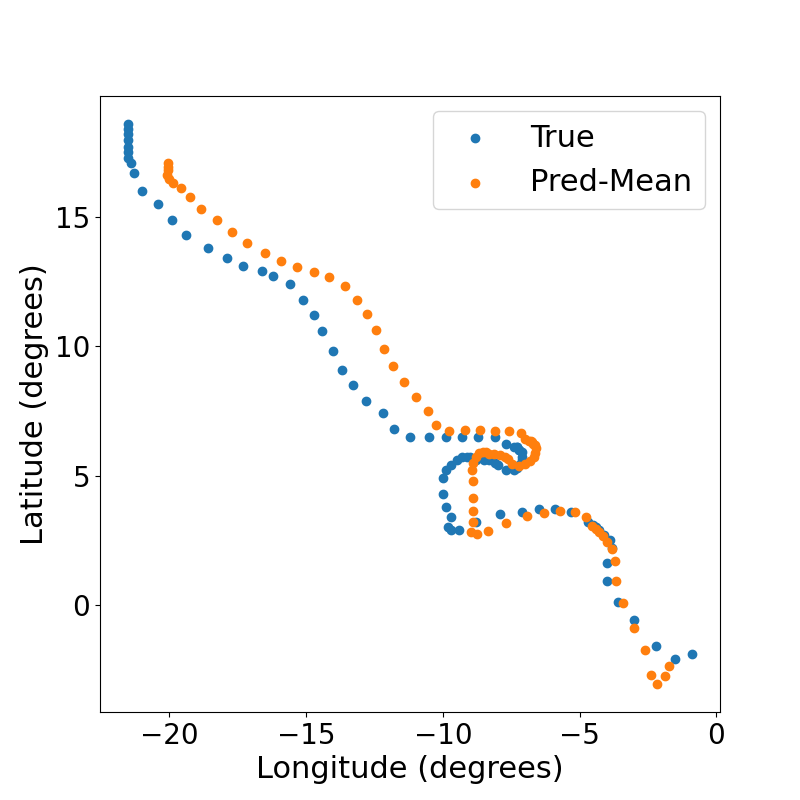

In [ ]:
#TODO: Add Documentation and clean up the notebook
#Write up
#References - Moving Pandas, Paper + Github Repo,
#Evaluation + Results